##### Load the dataset

In [ ]:
import pickle
import pandas as pd
import gdown

pklurl = 'https://drive.google.com/uc?id=1VXopPUT5WSojtqJ2TqD9Nnp08FePcOSp'

gdown.download(pklurl, 'data.pkl', quiet=False)
pd.set_option('display.max_columns', None)

df = pd.read_pickle('data.pkl')

Downloading...
From (original): https://drive.google.com/uc?id=1VXopPUT5WSojtqJ2TqD9Nnp08FePcOSp
From (redirected): https://drive.google.com/uc?id=1VXopPUT5WSojtqJ2TqD9Nnp08FePcOSp&confirm=t&uuid=1a2a6799-a046-4407-8bd3-d15f63e1f701
To: /content/data.pkl
100%|██████████| 165M/165M [00:02<00:00, 71.8MB/s]


## Prepare Data for training

#### Change the column names, fill the missing data

In [ ]:
season_map = {
    1: 'Winter', 2: 'Winter', 12: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
}
# Introduce the Season by mapping month number to the season_map dict
df['Season'] = df['MONTH_NUMBER'].map(season_map)


# if its not present than it is false, only the true values are filled in the data we have
df['IS_HOLIDAY_LEAVE'] = df['IS_HOLIDAY_LEAVE'].fillna(False)

df = df.rename(columns={
    'DAY_OF_WEEK': 'Day of Week',
    'IS_HOLIDAY_LEAVE': 'Is Holiday',
    'PRCP' : 'Precipitation',
    'SNOW' : 'Snow',
    'TOBS' : 'Temperature',
    'Census Tracts': 'Census',
    'Zip Codes': 'Zip Code'
})

# Select the data columns that will be used for the training
df_for_pred = df[['Day of Week', 'Is Holiday',
                  # Weather features
                  'Season', 'Precipitation', 'Snow', 'Temperature',
                  # Location-related features
                  'Block', 'Location Description', 'District', 'Ward',
                  'Community Area', 'Census', 'Zip Code',
                  'Latitude', 'Longitude',
                  # Label
                  'Primary Type']]



#### Drop the rows that have any missing data

In [ ]:
df_for_pred_cleaned = df_for_pred.dropna()
df_for_pred_cleaned.head()

,Day of Week,Is Holiday,Season,Precipitation,Snow,Temperature,Block,Location Description,District,Ward,Community Area,Census,Zip Code,Latitude,Longitude,Primary Type
3,6,1.0,Winter,0.0,0.0,26.0,014XX N KOLIN AVE,APARTMENT,25,26.0,23,286.0,4299.0,41.906877,-87.735033,OTHER OFFENSE
4,6,1.0,Winter,0.0,0.0,26.0,002XX W HURON ST,HOSPITAL BUILDING / GROUNDS,18,42.0,8,652.0,4446.0,41.894781,-87.634915,CRIMINAL SEXUAL ASSAULT
5,6,1.0,Winter,0.0,0.0,26.0,057XX S DAMEN AVE,APARTMENT,7,15.0,67,274.0,22257.0,41.789315,-87.674171,CRIMINAL DAMAGE
6,6,1.0,Winter,0.0,0.0,26.0,062XX S MICHIGAN AVE,STREET,3,20.0,40,404.0,22260.0,41.780946,-87.621995,CRIMINAL DAMAGE
7,6,1.0,Winter,0.0,0.0,26.0,031XX N RACINE AVE,APARTMENT,19,32.0,6,679.0,4449.0,41.939290,-87.658952,THEFT



#### Separating features and target label


In [ ]:
# Separate features and target label
X = df_for_pred_cleaned.drop('Primary Type', axis=1)
y = df_for_pred_cleaned['Primary Type']


#### Split data into testing and training datasets

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

In [ ]:
!pip install tensorflow

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import numpy as np

## Deep Learning
### Format Training and Testing Categorical Data

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
import numpy as np


categorical_columns = ['Block', 'Location Description', 'Season']
#categorical_columns = ['Season']

combined_categorical = pd.concat([X_train[categorical_columns], X_test[categorical_columns]])

label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    combined_categorical[col] = le.fit_transform(combined_categorical[col].astype(str))
    label_encoders[col] = le

X_train[categorical_columns] = combined_categorical.loc[X_train.index, categorical_columns]
X_test[categorical_columns] = combined_categorical.loc[X_test.index, categorical_columns]

numerical_columns = ['Precipitation', 'Snow', 'Temperature', 'Latitude', 'Longitude']
scaler = StandardScaler()

X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

y_encoder = LabelEncoder()
y_train_encoded = y_encoder.fit_transform(y_train)
y_test_encoded = y_encoder.transform(y_test)

y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)


X_train_reshaped = X_train.values.astype('float32')
X_test_reshaped = X_test.values.astype('float32')

X_train_reshaped = np.expand_dims(X_train_reshaped, axis=1)
X_test_reshaped = np.expand_dims(X_test_reshaped, axis=1)



### Run Random Forest Model and Plot Feature Importance

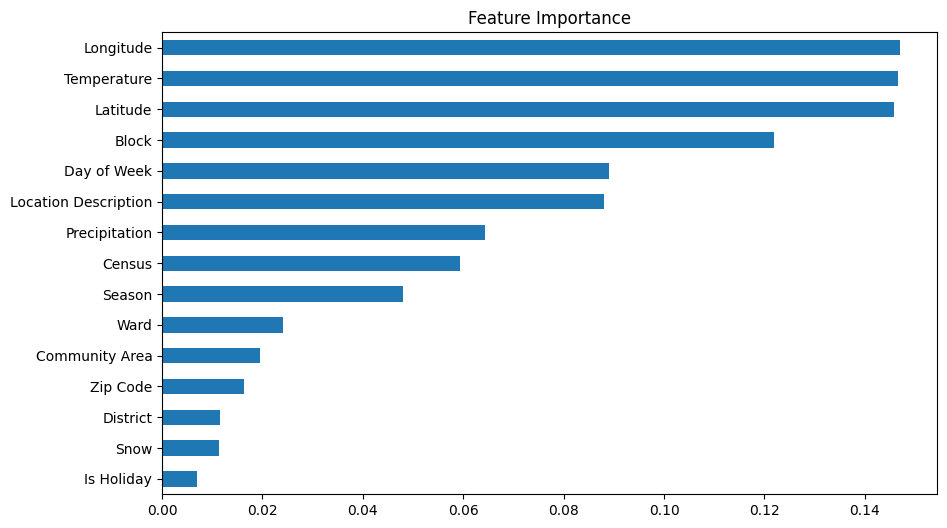

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd

rf = RandomForestClassifier(n_estimators=10, random_state=43)  # Reduce from 100 to 10
rf.fit(X_train, y_train_encoded)


# Plot feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feature_importances.sort_values().plot(kind='barh', figsize=(10, 6))
plt.title('Feature Importance')
plt.show()


### Re-categorize the training and testing datasets based on the feature importances

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
import numpy as np

categorical_columns = []
#I changed the categories we used to just these by seeing the importance from the random forest feature importance classifier
numerical_columns = ['Longitude', 'Latitude', 'Temperature']

combined_categorical = pd.concat([X_train[categorical_columns], X_test[categorical_columns]])

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    combined_categorical[col] = le.fit_transform(combined_categorical[col].astype(str))
    label_encoders[col] = le


X_train[categorical_columns] = combined_categorical.loc[X_train.index, categorical_columns]
X_test[categorical_columns] = combined_categorical.loc[X_test.index, categorical_columns]

scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

y_encoder = LabelEncoder()
y_train_encoded = y_encoder.fit_transform(y_train)
y_test_encoded = y_encoder.transform(y_test)

y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

X_train_refined = X_train[categorical_columns + numerical_columns].values.astype('float32')
X_test_refined = X_test[categorical_columns + numerical_columns].values.astype('float32')

X_train_reshaped = np.expand_dims(X_train_refined, axis=1)
X_test_reshaped = np.expand_dims(X_test_refined, axis=1)


### Set up a Long Short-Term Memory recurrent neural network

This was selected because of the prevalence of text in our label. Additionally, LSTMs are good at handling missing data and respect the order of data, which may prove to be a critical factor in analyzing crimes in Chicago

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(128, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(y_train_categorical.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weights = dict(enumerate(class_weights))

history = model.fit(
    X_train_reshaped, y_train_categorical,
    epochs=5,
    batch_size=256,
    validation_split=0.25,
    #class_weight=class_weights,  # Apply class weights
)


Epoch 1/5
988/988 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.2180 - loss: 2.5811 - val_accuracy: 0.2482 - val_loss: 2.3413
Epoch 2/5
988/988 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.2467 - loss: 2.3375 - val_accuracy: 0.2484 - val_loss: 2.3333
Epoch 3/5
988/988 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.2469 - loss: 2.3335 - val_accuracy: 0.2495 - val_loss: 2.3305
Epoch 4/5
988/988 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2471 - loss: 2.3290 - val_accuracy: 0.2501 - val_loss: 2.3271
Epoch 5/5
988/988 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2465 - loss: 2.3282 - val_accuracy: 0.2480 - val_loss: 2.3272


In [ ]:
loss, accuracy = model.evaluate(X_test_reshaped, y_test_categorical)
print(f"Test Accuracy: {accuracy:.2f}")

2633/2633 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.2474 - loss: 2.3286
Test Accuracy: 0.25


In [ ]:
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

predicted_crime_types = y_encoder.inverse_transform(y_pred_classes)
print(predicted_crime_types[:10])  # Show sample predictions

2633/2633 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
['THEFT' 'THEFT' 'BATTERY' 'BATTERY' 'BATTERY' 'BATTERY' 'THEFT' 'THEFT'
 'THEFT' 'BATTERY']


## **Conclusion**

Investigating the effects of tuning hyperparameters

For training hyperparameters, we varied the batch size, number of epochs, and optimizer choice.
When varying batch size, we found that larger batches produced a smoother convergence, but they took longer to run. The smaller batch sized took a noisier path toward convergence.
When varying the number of epochs, we started with a value of 40. However, this was definitely resulting in overfitting as we saw very minimal increases in optimization after the first few epochs. Therefore, we slowly dropped the number of epochs, shortening our processing time while not reducing accuracy.

We tried using two optimizers in our model: Adam and SGD. Ultimately, neither produced any noticeable improvement to our results. Both optimizers converged fairly quickly. We are still unsure which should be best suited for our extremely large dataset.

For testing hyperparameters we varied the testing dataset size. Ultimately we landed on 20% of the data being allocated to the testing dataset. Due to the enormity of our dataset, 20% can be easily spared without sacrificing training effectiveness while also providing a hearty dataset to test against.

For validation hyperparameters, we varied the validation dataset size as well. Similarly to the logic used with the testing dataset size, we settled on a value of 25%, which represents 20% of the overall dataset, or about 90,000 data points